In [3]:
from avalanche.benchmarks.classic import SplitCIFAR100, CORe50
from avalanche.training import Naive
from avalanche.models import SimpleMLP
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics, forgetting_metrics
from avalanche.logging import InteractiveLogger
from torch.optim import SGD
from torch.nn import CrossEntropyLoss


In [4]:
cifar100_benchmark = SplitCIFAR100(n_experiences=10, seed=1234, return_task_id=False)

Files already downloaded and verified
Files already downloaded and verified


In [40]:
model = SimpleMLP(input_size=3*32*32, num_classes=100)

In [5]:
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = CrossEntropyLoss()

# 设置评估插件
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, epoch=True, stream=True),
    loss_metrics(experience=True, epoch=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger()]
)

NameError: name 'model' is not defined

In [ ]:
# 使用 Naive 策略进行训练
strategy = Naive(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_mb_size=64,
    eval_mb_size=64,
    train_epochs=1,
    device="cuda"  # 或 "cpu"
)

In [56]:
from avalanche.training import Replay

strategy = Replay(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    mem_size=200,  # 设置存储的样本数量
    train_mb_size=64,
    eval_mb_size=64,
    train_epochs=1,
    device="cuda",  # 或 "cpu"
    evaluator=eval_plugin
)

In [47]:
from avalanche.training import EWC

strategy = EWC(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    ewc_lambda=0.4,  # 正则化强度
    train_mb_size=64,
    eval_mb_size=64,
    train_epochs=1,
    device="cuda",  # 或 "cpu"
)

In [63]:
from avalanche.training import SynapticIntelligence

strategy = SynapticIntelligence(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    si_lambda=1.0,  # 调整正则化强度
    train_mb_size=64,
    eval_mb_size=64,
    train_epochs=1,
    device="cuda",  # 或 "cpu"
)

In [2]:
from torchvision import transforms

# 数据预处理：添加展平操作
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # 归一化
    transforms.Lambda(lambda x: x.view(-1))  # 展平操作
])

# 创建 Split-CIFAR100 基准
cifar100_benchmark = SplitCIFAR100(
    n_experiences=10,
    seed=1234,
    return_task_id=False,
    train_transform=transform,
    eval_transform=transform
)

from avalanche.training import ICaRL
strategy = ICaRL(
    feature_extractor=model,
    classifier=model,
    optimizer=optimizer,
    memory_size=200,
    train_mb_size=64,
    eval_mb_size=64,
    train_epochs=1,
    device="cuda",  # 或 "cpu"
    buffer_transform=transform,
    fixed_memory=False
)

Files already downloaded and verified
Files already downloaded and verified


NameError: name 'model' is not defined

In [78]:
from avalanche.training import GEM
import torch
# 定义 GEM 策略
strategy = GEM(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    patterns_per_exp=200,
    train_mb_size=64,
    eval_mb_size=64,
    train_epochs=1,
    device="cuda" if torch.cuda.is_available() else "cpu",
    evaluator=eval_plugin
)

In [79]:
# 对每个经验进行训练
results = []
for experience in cifar100_benchmark.train_stream:
    print(f"Training on experience {experience.current_experience}")
    strategy.train(experience)
    results.append(strategy.eval(cifar100_benchmark.test_stream))


Training on experience 0
-- >> Start of training phase << --
0it [00:00, ?it/s]

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [64, 3072]

In [ ]:
import torch
from torch.nn import CrossEntropyLoss, Linear
from torch.optim import SGD
from avalanche.benchmarks.classic import SplitMNIST
from avalanche.training import ICaRL
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics, forgetting_metrics
from avalanche.logging import InteractiveLogger
from torchvision.transforms import Normalize, Compose

# 数据预处理
transform = Compose([
    Normalize((0.1307,), (0.3081,))  # MNIST 的标准化
])

# 创建 SplitMNIST 数据集
benchmark = SplitMNIST(
    n_experiences=5,
    seed=1234,
    return_task_id=False,
    train_transform=transform,
    eval_transform=transform
)

# 定义简单的 MLP 特征提取器
class SimpleMLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleMLP, self).__init__()
        self.hidden = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展平输入
        x = self.relu(self.hidden(x))
        return x

input_size = 28 * 28
hidden_size = 256
output_size = 10

# 特征提取器
feature_extractor = SimpleMLP(input_size, hidden_size)

# 分类器
classifier = Linear(hidden_size, output_size)

# 优化器和损失函数
optimizer = SGD(feature_extractor.parameters(), lr=0.01, momentum=0.9)
criterion = CrossEntropyLoss()

# 定义 buffer_transform 用于张量标准化
def buffer_transform(x):
    if isinstance(x, torch.Tensor):
        return (x - 0.5) / 0.5  # 张量标准化
    return x

# 设置评估插件
eval_plugin = EvaluationPlugin(
    accuracy_metrics(epoch=True, experience=True, stream=True),
    loss_metrics(epoch=True, experience=True, stream=True),
    forgetting_metrics(stream=True),
    loggers=[InteractiveLogger()]
)

# 定义 ICaRL 策略
strategy = ICaRL(
    feature_extractor=feature_extractor,
    classifier=classifier,
    optimizer=optimizer,
    memory_size=200,
    train_mb_size=64,
    eval_mb_size=64,
    train_epochs=1,
    device="cuda" if torch.cuda.is_available() else "cpu",
    evaluator=eval_plugin,
    buffer_transform=buffer_transform,
    fixed_memory=False
)

# 训练和评估
results = []
for experience in benchmark.train_stream:
    print(f"Training on experience {experience.current_experience}")
    strategy.train(experience)
    print(f"Evaluating on experience {experience.current_experience}")
    results.append(strategy.eval(benchmark.test_stream))


 18%|█▊        | 34/191 [00:19<00:02, 71.26it/s]Training on experience 0
-- >> Start of training phase << --
100%|██████████| 176/176 [00:01<00:00, 95.82it/s] 
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0800
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9221
-- >> End of training phase << --
Evaluating on experience 0
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 30/30 [00:00<00:00, 93.97it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.3800
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9872
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 32/32 [00:00<00:00, 91.59it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = 0.4511
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.0000
-- Starting eval on experience 2 (Task 0) from test 

In [6]:
import torch
from torch.nn import CrossEntropyLoss, Linear
from torch.optim import SGD
from torchvision.models import resnet18
from torchvision.transforms import Normalize, Compose, ToTensor
from avalanche.benchmarks.classic import SplitCIFAR100
from avalanche.training import ICaRL
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics, forgetting_metrics
from avalanche.logging import InteractiveLogger

# 数据预处理
transform = transforms.Compose([
    transforms.Resize(64),  # Tiny ImageNet images are 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 定义 buffer_transform 用于张量标准化
def buffer_transform(x):
    if isinstance(x, torch.Tensor):
        return (x - 0.5) / 0.5  # 张量标准化
    return x

# 创建 SplitCIFAR100 数据集
benchmark = SplitCIFAR100(
    n_experiences=10,  # 将 CIFAR-100 分为 10 个增量任务
    seed=1234,
    return_task_id=False,
    train_transform=transform,
    eval_transform=transform
)

# 定义 ResNet18 模型作为特征提取器
resnet_model = resnet18(pretrained=False)  # 不使用预训练权重
feature_extractor = torch.nn.Sequential(
    *list(resnet_model.children())[:-1],  # 移除分类层
    torch.nn.Flatten()  # 展平为 [batch_size, 512]
)
hidden_size = resnet_model.fc.in_features  # 特征提取器的输出维度

# 定义分类器
output_size = 100  # CIFAR-100 总类别数
classifier = Linear(hidden_size, output_size)

# 优化器和损失函数
optimizer = SGD(list(feature_extractor.parameters()) + list(classifier.parameters()), lr=0.01, momentum=0.9)
criterion = CrossEntropyLoss()

# 设置评估插件
eval_plugin = EvaluationPlugin(
    accuracy_metrics(epoch=True, experience=True, stream=True),
    loss_metrics(epoch=True, experience=True, stream=True),
    forgetting_metrics(stream=True),
    loggers=[InteractiveLogger()]
)

# 定义 ICaRL 策略
strategy = ICaRL(
    feature_extractor=feature_extractor,
    classifier=classifier,
    optimizer=optimizer,
    memory_size=2000,  # 存储池大小
    train_mb_size=64,
    eval_mb_size=64,
    train_epochs=1,
    device="cuda" if torch.cuda.is_available() else "cpu",
    evaluator=eval_plugin,
    buffer_transform=buffer_transform,  # 使用适合张量的标准化函数
    fixed_memory=False
)

# 训练和评估
results = []
for experience in benchmark.train_stream:
    print(f"Training on experience {experience.current_experience}")
    strategy.train(experience)  # 训练
    print(f"Evaluating on experience {experience.current_experience}")
    results.append(strategy.eval(benchmark.test_stream))  # 评估


Files already downloaded and verified
Files already downloaded and verified


/home/yangz2/anaconda3/envs/quan_cl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yangz2/anaconda3/envs/quan_cl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training on experience 0
-- >> Start of training phase << --
100%|██████████| 79/79 [00:04<00:00, 17.46it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1887
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1088


KeyboardInterrupt: 

In [73]:
import torch
import torchvision.transforms as transforms
from avalanche.benchmarks import SplitCIFAR100
from avalanche.models import make_icarl_net
from avalanche.training.plugins import EvaluationPlugin
from avalanche.training import LwF
from avalanche.evaluation.metrics import accuracy_metrics, forgetting_metrics, loss_metrics
from avalanche.logging import InteractiveLogger, TextLogger

# Hyperparameters
BATCH_SIZE = 128
NUM_CLASSES = 100
CLASS_INCREMENT = 10
EPOCHS = 30
LR = 0.1
ALPHA = 1.0  # LwF distillation loss weight
TEMPERATURE = 2.0  # Temperature for knowledge distillation

# Data preparation
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
])

data = SplitCIFAR100(n_experiences=NUM_CLASSES // CLASS_INCREMENT, seed=1, dataset_root='./data', train_transform=transform, eval_transform=transform)

# Model definition
from torchvision.models import resnet18
class IncrementalResNet18(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.feature_extractor = resnet18(pretrained=True)
        self.feature_extractor.fc = torch.nn.Linear(512, num_classes)

    def forward(self, x):
        return self.feature_extractor(x)

model = IncrementalResNet18(num_classes=NUM_CLASSES)

# Logger and evaluation plugin
interactive_logger = InteractiveLogger()
eval_plugin = EvaluationPlugin(
    accuracy_metrics(epoch=True, experience=True, stream=True),
    loss_metrics(epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
    loggers=[interactive_logger, TextLogger(open("results.txt", "w"))]
)

# Strategy definition
strategy = LwF(
    model,
    optimizer=torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4),
    criterion=torch.nn.CrossEntropyLoss(),
    alpha=ALPHA,
    temperature=TEMPERATURE,
    train_mb_size=BATCH_SIZE,
    train_epochs=EPOCHS,
    eval_mb_size=BATCH_SIZE,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    evaluator=eval_plugin
)

# Training loop
print("Starting training with Avalanche LwF...")
results = []
for experience in data.train_stream:
    print(f"Training on experience {experience.current_experience} with classes {experience.classes_in_this_experience}")
    strategy.train(experience, eval_stream=data.test_stream)
    print("Evaluation...")
    results.append(strategy.eval(data.test_stream))


Files already downloaded and verified
Files already downloaded and verified
Starting training with Avalanche LwF...
Training on experience 0 with classes [32, 96, 35, 72, 45, 15, 79, 17, 90, 63]
-- >> Start of training phase << --
100%|██████████| 40/40 [00:02<00:00, 15.04it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 4.6633
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1342
100%|██████████| 40/40 [00:02<00:00, 14.31it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 4.6130
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1144
100%|██████████| 40/40 [00:02<00:00, 13.37it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.9174
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1224
100%|██████████| 40/40 [00:02<00:00, 15.08it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.1314
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1524
100%|██████████| 40/40 [00:03<00:00, 13.20it/s]
Epoch 4 ended.
	Loss_

In [107]:
import pickle

# 存储到文件
with open("results/list/CIFAR100_ICaRL_cls_tepoch30.pkl", "wb") as f:
    pickle.dump(results, f)  

In [109]:

# 从文件加载
with open("results/list/CIFAR100_ICaRL_cls_tepoch30.pkl", "rb") as f:
    results = pickle.load(f)  

[{'Top1_Acc_Epoch/train_phase/train_stream/Task000': 0.7342, 'Loss_Epoch/train_phase/train_stream/Task000': 0.01726297096610069, 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.528, 'Loss_Exp/eval_phase/test_stream/Task000/Exp000': 0.3329102642536163, 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001': 0.0, 'Loss_Exp/eval_phase/test_stream/Task000/Exp001': 0.33877219176292417, 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002': 0.0, 'Loss_Exp/eval_phase/test_stream/Task000/Exp002': 0.3391953411102295, 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003': 0.0, 'Loss_Exp/eval_phase/test_stream/Task000/Exp003': 0.3389410631656647, 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004': 0.0, 'Loss_Exp/eval_phase/test_stream/Task000/Exp004': 0.33915312552452087, 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp005': 0.0, 'Loss_Exp/eval_phase/test_stream/Task000/Exp005': 0.33878811287879945, 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp006': 0.0, 'Loss_Exp/eval_phase/test_stream/

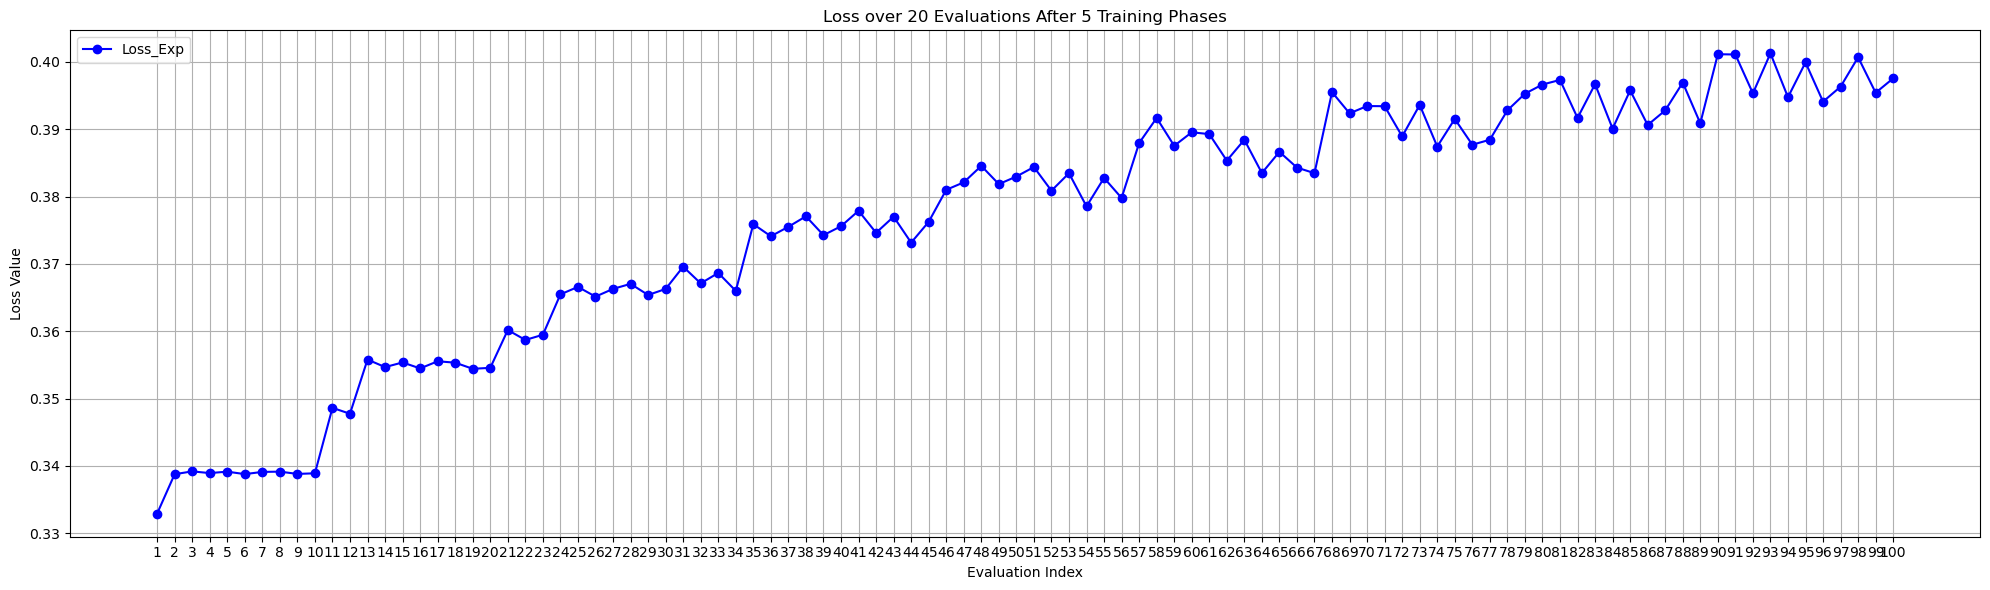

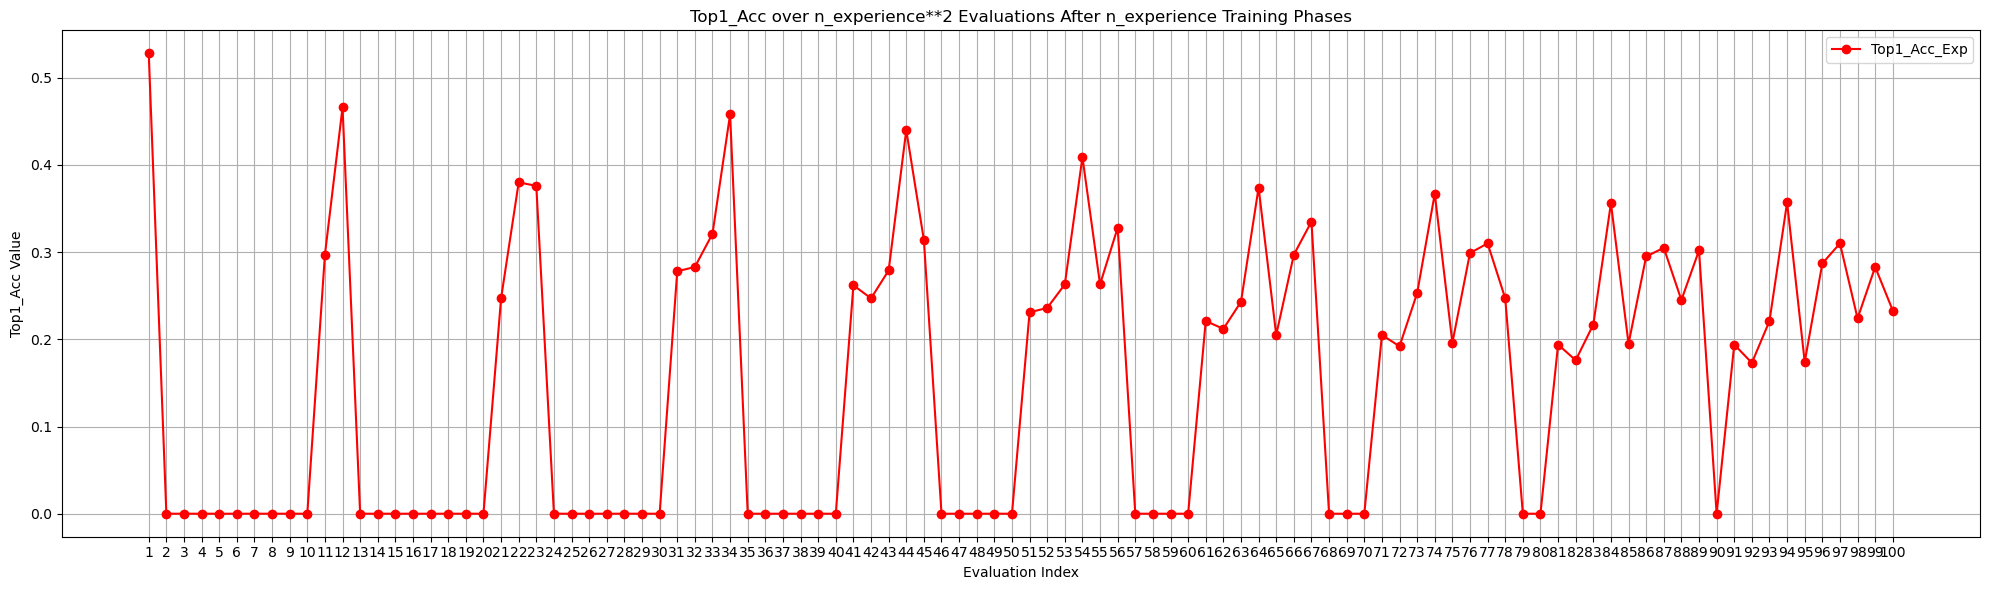

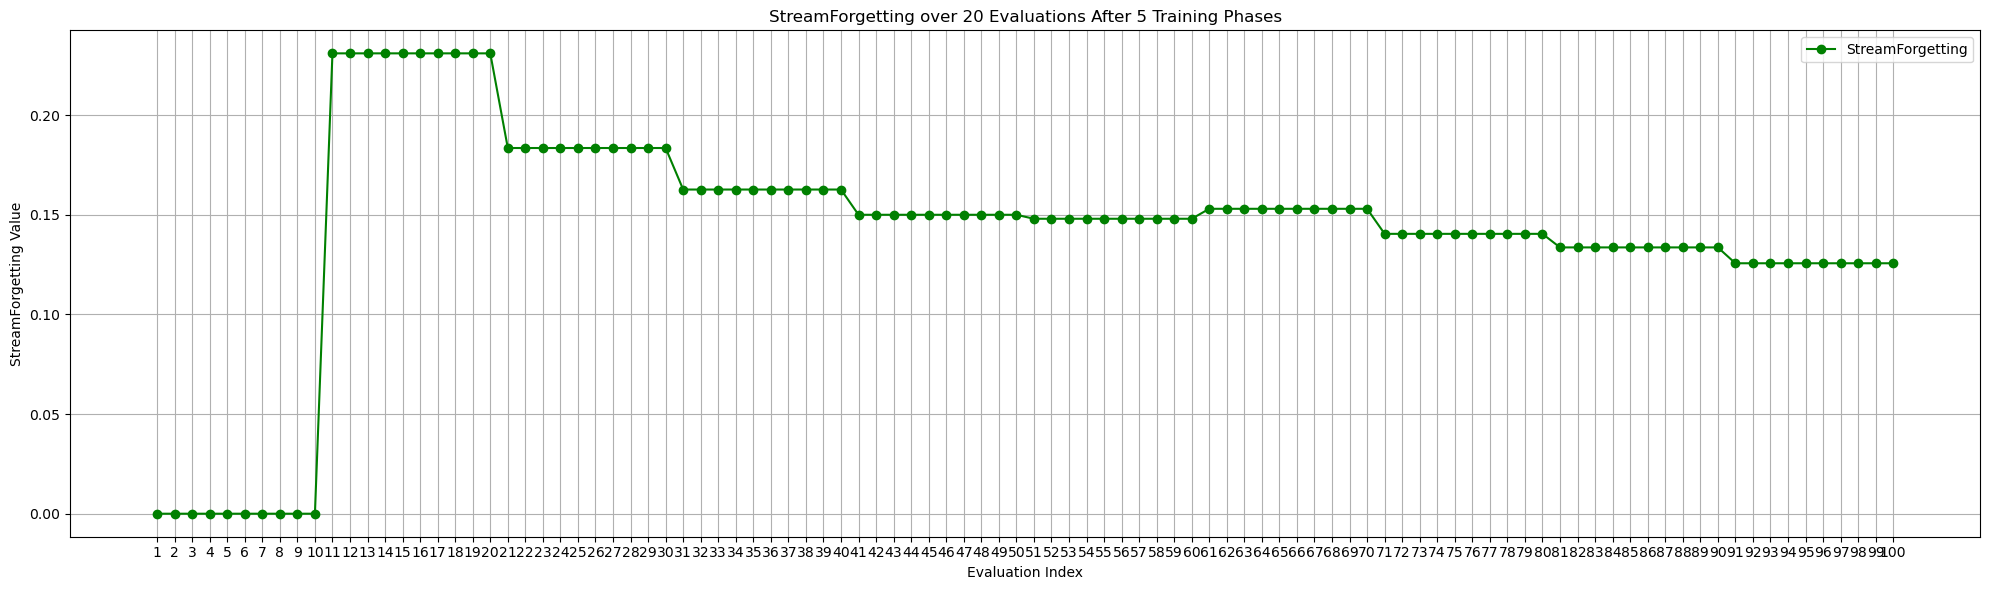

In [110]:
import matplotlib.pyplot as plt
# 初始化列表来存储 Loss 值
loss_values = []
x = []  # x 轴：经验编号（1-20）
num_experiences = 10
print(results)

# 遍历 results 提取 Loss_Exp 数据
count = 1  # 用于标记经验编号
for train_idx, result in enumerate(results):  # 遍历5次训练的结果
    for exp_id in range(0, num_experiences):  # 每次训练对应4次 eval（Exp001 到 Exp004）
        key = f"Loss_Exp/eval_phase/test_stream/Task000/Exp00{exp_id}"
        loss = result.get(key, None)
        if loss is not None:  # 确保键存在
            loss_values.append(loss)
            x.append(count)  # x 轴连续编号
            count += 1

# 遍历 results 提取 Top1_Acc_Exp 数据
top1_acc_values = []
for train_idx, result in enumerate(results):  # 遍历5次训练的结果
    for exp_id in range(0, num_experiences):  # 每次训练对应4次 eval（Exp001 到 Exp004）
        key = f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00{exp_id}"
        top1_acc = result.get(key, None)
        if top1_acc is not None:  # 确保键存在
            top1_acc_values.append(top1_acc)

# 遍历 resutls 中的 Forgetting 数据, 但是是每个stream的Forgetting
forgetting_values = []
for train_idx, result in enumerate(results):  # 遍历5次训练的结果
    for exp_id in range(0, num_experiences):  # 每次训练对应4次 eval（Exp001 到 Exp004）
        key = f"StreamForgetting/eval_phase/test_stream"
        forgetting = result.get(key, None)
        if forgetting is not None:  # 确保键存在
            forgetting_values.append(forgetting)


# 绘制图形
plt.figure(figsize=(20, 6))
plt.plot(x, loss_values, marker='o', linestyle='-', color='b', label='Loss_Exp')
plt.title("Loss over 20 Evaluations After 5 Training Phases")
plt.xlabel("Evaluation Index")
plt.ylabel("Loss Value")
plt.xticks(range(1, len(x) + 1))  # 设置 x 轴刻度
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(x, top1_acc_values, marker='o', linestyle='-', color='r', label='Top1_Acc_Exp')
plt.title("Top1_Acc over n_experience**2 Evaluations After n_experience Training Phases")
plt.xlabel("Evaluation Index")
plt.ylabel("Top1_Acc Value")
plt.xticks(range(1, len(x) + 1))  # 设置 x 轴刻度
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(range(1, len(forgetting_values) + 1), forgetting_values, marker='o', linestyle='-', color='g', label='StreamForgetting')
plt.title("StreamForgetting over 20 Evaluations After 5 Training Phases")
plt.xlabel("Evaluation Index")
plt.ylabel("StreamForgetting Value")
plt.xticks(range(1, len(forgetting_values) + 1))  # 设置 x 轴刻度
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()